In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import pickle

### Regressive Modeling

In [2]:
def generate_supervised(data):
    supervised = data.copy()
    
    # Creating column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised[col_name] = supervised['sales_diff'].shift(i)
    
    # Dropping null values
    supervised = supervised.dropna().reset_index(drop=True)
    
    supervised.to_csv('../data/input/model.csv', index=False)
    
    return supervised

In [3]:
stationary = pd.read_csv('../data/input/stationary.csv')
model_df = generate_supervised(stationary)

### ARIMA Modeling

In [4]:
def generate_arima_data(data):
    dt_data = data.set_index('orderDate').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../data/output/arima.csv')
    
    return dt_data

In [5]:
datetime_df = generate_arima_data(stationary)
datetime_df

,Unnamed: 0,sales_diff
orderDate,,
2015-01-10,1,-1426.9980
2016-01-10,2,963.2740
2017-01-10,3,-843.3540
2015-01-11,4,-164.8100
2017-01-11,5,139.5040
...,...,...
2015-09-08,1110,11305.7610
2016-09-08,1111,-14138.7880
2017-09-08,1112,4404.3436


#### Loading the ARIMA Data

In [6]:
def load_data():
    return pd.read_csv('../data/output/arima.csv').set_index('orderDate')

arm_data = load_data()

In [7]:
arm_data.index = pd.to_datetime(arm_data.index)

### SARIMAX Modeling

In [8]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "../data/output/arima_model_scores.p", "wb" ))

/Users/yalim/Dev/order-forecaster/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yalim/Dev/order-forecaster/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/yalim/Dev/order-forecaster/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yalim/Dev/order-forecaster/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27411D+00    |proj g|=  2.37488D-03

At iterate    5    f=  9.27410D+00    |proj g|=  9.04263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14      9     12      1     0     0   8.582D-05   9.274D+00
  F =   9.2741000483785587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Checkpoint
RMSE: 1881.1756712622034
MAE: 1517.2335453271487
R2 Score: 0.005289702668369922


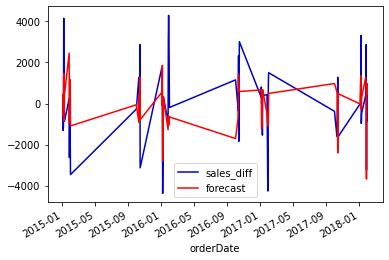

In [9]:
def sarimax_model(data):
    # Model
    sar = sm.tsa.statespace.SARIMAX(arm_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    print('Checkpoint')
    data = data.dropna()
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, arm_data, predictions = sarimax_model(arm_data)

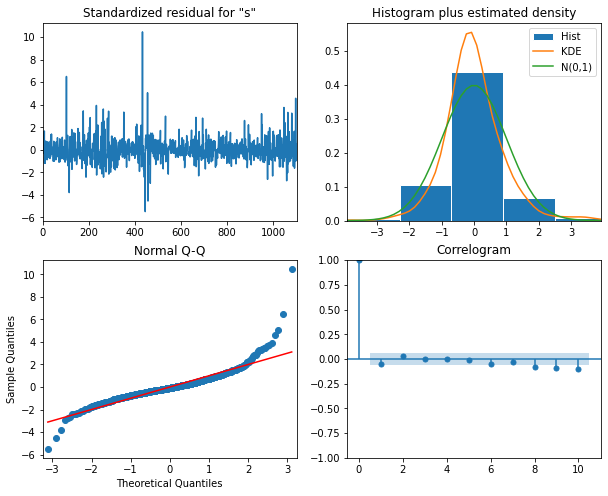

In [10]:
sar.plot_diagnostics(figsize=(10, 8));

### Conclusion

In [11]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('../data/input/model.csv')
    original_df.date = original_df.orderDate.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('orderDate')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.orderDate)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].orderDate)
    act_sales = list(original_df[-13:].sales)
    
    for i in range(0, len(prediction_df)):
        if i < len(sales_dates) - 1:
            result_dict = {}
            result_dict['pred_value'] = int(prediction_df[i] + act_sales[i])
            result_dict['date'] = sales_dates[i+1]
            result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [12]:
def plot_results(results, original_df):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Orders",
           title = f"Arima Order Forecaster")
    
    ax.legend()
    
    sns.despine()

    plt.savefig('../data/model_output/arima_forecast.png')

/var/folders/yp/lt2d6kgx5t31h71crmjvs__80000gn/T/ipykernel_89498/1693025742.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.date = original_df.orderDate.apply(lambda x: str(x)[:-3])
/var/folders/yp/lt2d6kgx5t31h71crmjvs__80000gn/T/ipykernel_89498/1693025742.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original_df.date = pd.to_datetime(original_df.orderDate)
/Users/yalim/Dev/order-forecaster/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yalim/Dev/order-forec

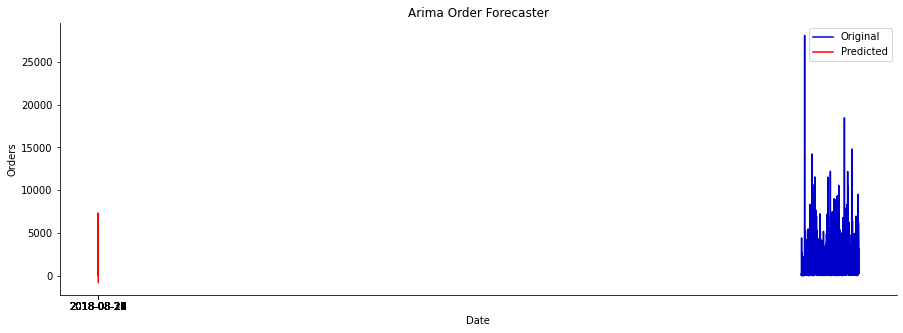

In [13]:
prediction_df, original_df = predict_df(predictions)
prediction_df.to_csv('../data/output/pred.csv', index=False)
original_df.to_csv('../data/output/original.csv', index=False)
plot_results(prediction_df, original_df)